# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [77]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [78]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [79]:
import os
os.listdir("test_images/")

['solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteRight.jpg',
 'solidWhiteCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowLeft.jpg']

run your solution on all test_images and make copies into the test_images directory).

In [81]:
def do_blur(image):
    smoothed = gaussian_blur(image,3)
    

In [137]:
if True: print('hello')

hello


In [150]:
def process_image(image, debug=False):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    gray = grayscale(image)
    if(debug):
        plt.figure()
        plt.title('gray')
        plt.imshow(gray, cmap='gray')
    
    blurred = gaussian_blur(gray,3)
    if(debug):
        plt.figure()
        plt.title('blurred')
        plt.imshow(blurred, cmap='gray')
    
    cannied = canny(blurred,low_threshold=30,high_threshold=100)
    if(debug):
        plt.figure()
        plt.title('canny')
        plt.imshow(cannied, cmap='gray')
    
    
    h,w,_=image.shape
    lborder = 100
    rborder = 30
    top = 320
    gap = 30
    bottom = h
    poly = [(lborder,bottom-1),(w/2-gap,top),(w/2+gap,top),(w-rborder,bottom-1)]
    print(poly)
    interesting = region_of_interest(cannied, np.int32([poly]))

    #todo: only have one hough
    lines = cv2.HoughLinesP(interesting, rho = 3, theta = 2 * math.pi/180., threshold=5, minLineLength=30, maxLineGap=10)
    houghed = interesting.copy()
    draw_lines(houghed, lines)

    #houghed = hough_lines(interesting, rho = 3, theta = 2 * math.pi/180., threshold =5, min_line_len=30, max_line_gap=10)
    if(debug):
        plt.figure()
        plt.title('houghed')
        plt.imshow(houghed, cmap='gray')

    cv2.polylines(image, np.int32([poly]), True, (0,0,255),3)
    
    left_lines = []
    right_lines = []
    rejected_lines = []
    
    # find left and right lines
    for line in lines:
        for x1,y1,x2,y2 in line:
            if(x2<x1):
                x2,x1 = x1,x2
                y2,y1 = y1,y2
            slope = math.atan2(-(y2-y1),x2-x1)*180./math.pi
            if slope > 25 and slope < 50:
                left_lines.append([(x1,y1,x2,y2)])
                if debug: print("left slope :{}".format(slope))
            elif slope > -50 and slope < -25:
                right_lines.append([(x1,y1,x2,y2)])
                if debug: print("right slope :{}".format(slope))
            else:
                rejected_lines.append([(x1,y1,x2,y2)])
                if debug: print("rejected slope :{}".format(slope))
    
    draw_lines(image, left_lines, [255,0,0])
    draw_lines(image, right_lines, [0,255,0])
    draw_lines(image, rejected_lines, [0,0,0])
    
    
    # find single left and right line
    #single_left_line = lane_line_from_lines(left_lines, poly)
    #single_right_line = lane_line_from_lines(right_lines, poly)
    #draw_lines(image, lines)
    return image


processing test_images/solidYellowCurve.jpg
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
processing test_images/solidYellowCurve2.jpg
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
processing test_images/solidWhiteRight.jpg
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
processing test_images/solidWhiteCurve.jpg
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
processing test_images/whiteCarLaneSwitch.jpg
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
processing test_images/solidYellowLeft.jpg
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


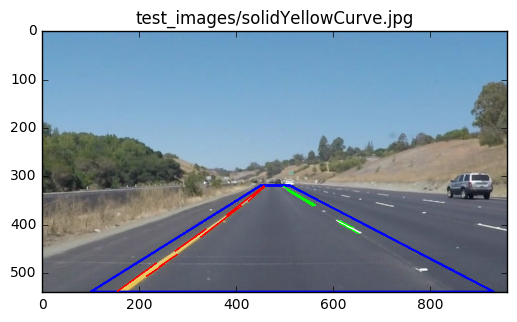

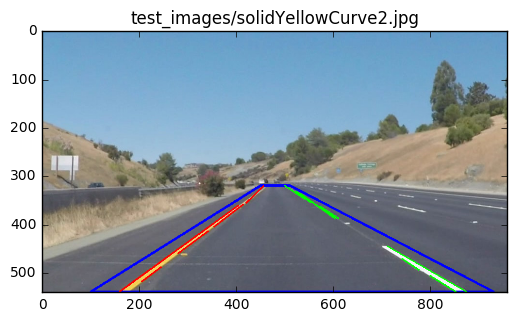

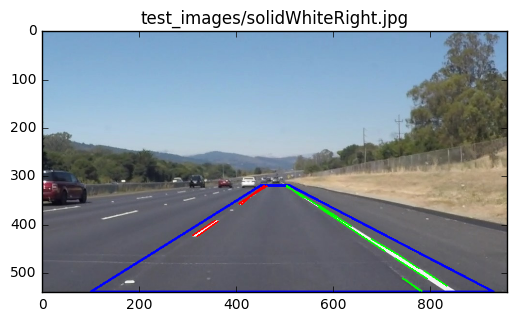

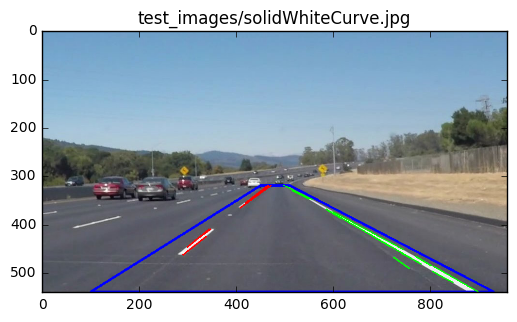

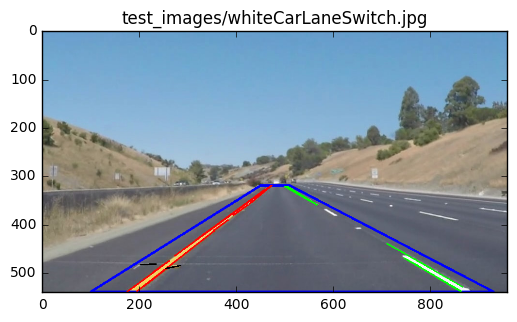

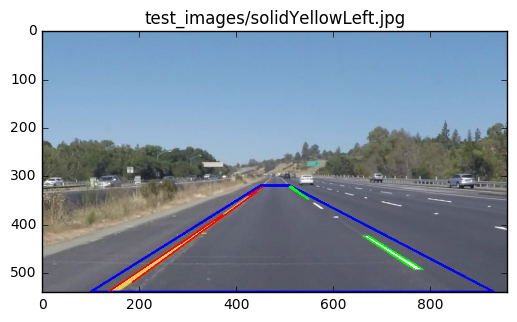

In [151]:
folder = "test_images"
for file_name in os.listdir(folder):
    file_path = "/".join([folder , file_name])
    print("processing {}".format(file_path))
    #reading in an image
    image = mpimg.imread(file_path)
    #printing out some stats and plotting
    #print('This image is:', type(image), 'with dimesions:', image.shape)
    #plt.figure()
    #plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
    processed = process_image(image, debug=False)
    plt.figure()
    plt.title(file_path)
    plt.imshow(processed)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [140]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [141]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  0%|          | 1/222 [00:00<00:58,  3.75it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  1%|▏         | 3/222 [00:01<01:07,  3.23it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  2%|▏         | 4/222 [00:01<01:00,  3.58it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  3%|▎         | 6/222 [00:01<00:51,  4.21it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  4%|▎         | 8/222 [00:01<00:40,  5.25it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  5%|▍         | 10/222 [00:02<00:42,  4.99it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  5%|▍         | 11/222 [00:02<00:46,  4.49it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  6%|▌         | 13/222 [00:02<00:38,  5.48it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  6%|▋         | 14/222 [00:03<00:39,  5.30it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  7%|▋         | 16/222 [00:03<00:37,  5.54it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  8%|▊         | 18/222 [00:03<00:36,  5.60it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 10%|▉         | 22/222 [00:04<00:30,  6.53it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 10%|█         | 23/222 [00:04<00:42,  4.65it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 11%|█▏        | 25/222 [00:05<00:34,  5.73it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 12%|█▏        | 26/222 [00:05<00:33,  5.77it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 13%|█▎        | 28/222 [00:05<00:35,  5.44it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 13%|█▎        | 29/222 [00:05<00:41,  4.70it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 14%|█▍        | 31/222 [00:06<00:34,  5.51it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 15%|█▌        | 34/222 [00:06<00:29,  6.37it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 16%|█▌        | 35/222 [00:06<00:37,  4.98it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 17%|█▋        | 38/222 [00:07<00:32,  5.71it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 18%|█▊        | 40/222 [00:07<00:28,  6.33it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 18%|█▊        | 41/222 [00:07<00:26,  6.72it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 19%|█▉        | 43/222 [00:08<00:30,  5.85it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 20%|█▉        | 44/222 [00:08<00:31,  5.73it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 21%|██        | 46/222 [00:08<00:38,  4.52it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 21%|██        | 47/222 [00:09<00:49,  3.53it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 22%|██▏       | 48/222 [00:09<00:54,  3.18it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 23%|██▎       | 50/222 [00:10<00:58,  2.93it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 23%|██▎       | 51/222 [00:11<01:20,  2.11it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 23%|██▎       | 52/222 [00:11<01:19,  2.14it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 24%|██▍       | 54/222 [00:12<01:08,  2.45it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 25%|██▌       | 56/222 [00:13<01:00,  2.75it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 26%|██▌       | 57/222 [00:13<00:58,  2.83it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 27%|██▋       | 59/222 [00:14<00:57,  2.85it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 27%|██▋       | 60/222 [00:14<00:50,  3.20it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 27%|██▋       | 61/222 [00:14<01:05,  2.46it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 28%|██▊       | 62/222 [00:15<01:04,  2.49it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 28%|██▊       | 63/222 [00:15<01:02,  2.53it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 29%|██▉       | 65/222 [00:16<00:51,  3.07it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 30%|███       | 67/222 [00:17<00:54,  2.86it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 31%|███       | 68/222 [00:17<00:50,  3.07it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 32%|███▏      | 70/222 [00:17<00:45,  3.36it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 33%|███▎      | 73/222 [00:18<00:36,  4.06it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 34%|███▍      | 75/222 [00:19<00:41,  3.55it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 35%|███▍      | 77/222 [00:19<00:33,  4.39it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 36%|███▌      | 79/222 [00:20<00:34,  4.18it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 36%|███▋      | 81/222 [00:20<00:39,  3.54it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 37%|███▋      | 82/222 [00:21<00:41,  3.35it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 37%|███▋      | 83/222 [00:21<00:42,  3.28it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 38%|███▊      | 85/222 [00:21<00:39,  3.51it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 39%|███▉      | 87/222 [00:22<00:36,  3.67it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 40%|███▉      | 88/222 [00:22<00:37,  3.61it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 40%|████      | 89/222 [00:22<00:34,  3.84it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 41%|████      | 90/222 [00:23<00:34,  3.78it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 41%|████      | 91/222 [00:23<00:36,  3.57it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 42%|████▏     | 93/222 [00:24<00:34,  3.69it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 42%|████▏     | 94/222 [00:24<00:32,  3.92it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 43%|████▎     | 96/222 [00:24<00:34,  3.68it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 44%|████▎     | 97/222 [00:25<00:31,  4.02it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 44%|████▍     | 98/222 [00:25<00:29,  4.27it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 45%|████▌     | 100/222 [00:25<00:30,  4.00it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 46%|████▋     | 103/222 [00:26<00:24,  4.80it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 47%|████▋     | 105/222 [00:27<00:31,  3.72it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 48%|████▊     | 106/222 [00:27<00:27,  4.18it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 48%|████▊     | 107/222 [00:27<00:31,  3.69it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 49%|████▊     | 108/222 [00:27<00:29,  3.91it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 49%|████▉     | 109/222 [00:28<00:30,  3.66it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 50%|█████     | 112/222 [00:28<00:24,  4.41it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 51%|█████     | 113/222 [00:29<00:24,  4.42it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 52%|█████▏    | 115/222 [00:29<00:27,  3.83it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 53%|█████▎    | 117/222 [00:30<00:26,  3.90it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 54%|█████▎    | 119/222 [00:30<00:28,  3.60it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 55%|█████▍    | 121/222 [00:31<00:28,  3.51it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 55%|█████▍    | 122/222 [00:31<00:33,  3.00it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 56%|█████▌    | 124/222 [00:32<00:29,  3.37it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 56%|█████▋    | 125/222 [00:32<00:29,  3.32it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 57%|█████▋    | 126/222 [00:33<00:34,  2.80it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 58%|█████▊    | 128/222 [00:34<00:33,  2.81it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 58%|█████▊    | 129/222 [00:34<00:38,  2.44it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 59%|█████▊    | 130/222 [00:34<00:35,  2.58it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 59%|█████▉    | 131/222 [00:35<00:35,  2.54it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 60%|█████▉    | 133/222 [00:36<00:30,  2.90it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 60%|██████    | 134/222 [00:36<00:30,  2.86it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 61%|██████    | 135/222 [00:36<00:31,  2.79it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 61%|██████▏   | 136/222 [00:37<00:35,  2.45it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 62%|██████▏   | 138/222 [00:37<00:27,  3.05it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 63%|██████▎   | 140/222 [00:38<00:30,  2.73it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 64%|██████▎   | 141/222 [00:39<00:29,  2.70it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 64%|██████▍   | 143/222 [00:39<00:23,  3.35it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 65%|██████▌   | 145/222 [00:40<00:24,  3.17it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 66%|██████▌   | 146/222 [00:40<00:26,  2.92it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 67%|██████▋   | 148/222 [00:41<00:25,  2.88it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 67%|██████▋   | 149/222 [00:41<00:24,  3.02it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 68%|██████▊   | 151/222 [00:42<00:21,  3.34it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 68%|██████▊   | 152/222 [00:42<00:24,  2.85it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 69%|██████▉   | 154/222 [00:43<00:23,  2.94it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 70%|██████▉   | 155/222 [00:43<00:19,  3.45it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 70%|███████   | 156/222 [00:43<00:20,  3.24it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 71%|███████   | 158/222 [00:44<00:19,  3.30it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 72%|███████▏  | 160/222 [00:45<00:19,  3.18it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 73%|███████▎  | 161/222 [00:45<00:18,  3.30it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 73%|███████▎  | 162/222 [00:45<00:18,  3.33it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 74%|███████▍  | 164/222 [00:46<00:19,  3.04it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 74%|███████▍  | 165/222 [00:46<00:18,  3.15it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 75%|███████▌  | 167/222 [00:47<00:16,  3.24it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 76%|███████▌  | 169/222 [00:48<00:14,  3.68it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 77%|███████▋  | 170/222 [00:48<00:15,  3.25it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 77%|███████▋  | 172/222 [00:49<00:14,  3.39it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 78%|███████▊  | 173/222 [00:49<00:13,  3.58it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 79%|███████▉  | 175/222 [00:49<00:14,  3.22it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 79%|███████▉  | 176/222 [00:50<00:12,  3.70it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 80%|███████▉  | 177/222 [00:50<00:12,  3.60it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 81%|████████  | 179/222 [00:51<00:12,  3.39it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 82%|████████▏ | 181/222 [00:51<00:11,  3.63it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 82%|████████▏ | 182/222 [00:52<00:11,  3.39it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 83%|████████▎ | 184/222 [00:52<00:12,  3.02it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 84%|████████▍ | 186/222 [00:53<00:12,  2.84it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 85%|████████▍ | 188/222 [00:54<00:09,  3.40it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 85%|████████▌ | 189/222 [00:54<00:09,  3.36it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 86%|████████▌ | 190/222 [00:54<00:10,  3.09it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 86%|████████▌ | 191/222 [00:55<00:10,  2.92it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 87%|████████▋ | 193/222 [00:55<00:09,  2.93it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 88%|████████▊ | 195/222 [00:56<00:07,  3.59it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 89%|████████▊ | 197/222 [00:56<00:06,  3.73it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 89%|████████▉ | 198/222 [00:57<00:06,  3.44it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 90%|████████▉ | 199/222 [00:57<00:07,  3.19it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 90%|█████████ | 200/222 [00:57<00:07,  3.04it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 91%|█████████ | 202/222 [00:58<00:06,  3.12it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 91%|█████████▏| 203/222 [00:58<00:05,  3.46it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 92%|█████████▏| 204/222 [00:58<00:04,  3.76it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 93%|█████████▎| 206/222 [00:59<00:05,  2.96it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 93%|█████████▎| 207/222 [00:59<00:04,  3.72it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 94%|█████████▍| 209/222 [01:00<00:03,  3.32it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 95%|█████████▌| 211/222 [01:01<00:03,  3.44it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 95%|█████████▌| 212/222 [01:01<00:03,  3.24it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 96%|█████████▋| 214/222 [01:02<00:02,  2.88it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 97%|█████████▋| 215/222 [01:02<00:02,  3.15it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 97%|█████████▋| 216/222 [01:03<00:02,  2.86it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 98%|█████████▊| 217/222 [01:03<00:01,  2.71it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 99%|█████████▊| 219/222 [01:04<00:01,  2.66it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 99%|█████████▉| 220/222 [01:04<00:00,  2.70it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


100%|█████████▉| 221/222 [01:05<00:00,  2.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 30.1 s, sys: 3.89 s, total: 33.9 s
Wall time: 1min 11s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [145]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [71]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  0%|          | 0/682 [00:00<?, ?it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  0%|          | 1/682 [00:00<05:49,  1.95it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  0%|          | 3/682 [00:01<04:23,  2.58it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  1%|          | 5/682 [00:01<03:00,  3.74it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  1%|          | 7/682 [00:01<02:15,  4.99it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  1%|▏         | 9/682 [00:01<01:54,  5.86it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  1%|▏         | 10/682 [00:02<01:44,  6.40it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  2%|▏         | 13/682 [00:02<01:37,  6.87it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  2%|▏         | 15/682 [00:02<01:39,  6.69it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  2%|▏         | 16/682 [00:02<01:34,  7.07it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  3%|▎         | 19/682 [00:03<01:36,  6.86it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  3%|▎         | 20/682 [00:03<02:10,  5.07it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  3%|▎         | 21/682 [00:03<02:05,  5.26it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  3%|▎         | 23/682 [00:04<02:33,  4.28it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  4%|▎         | 25/682 [00:04<02:01,  5.39it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  4%|▍         | 27/682 [00:05<02:04,  5.25it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  4%|▍         | 29/682 [00:05<01:53,  5.76it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  4%|▍         | 30/682 [00:05<01:55,  5.67it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  5%|▍         | 32/682 [00:05<01:53,  5.72it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  5%|▍         | 34/682 [00:06<02:04,  5.19it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  5%|▌         | 35/682 [00:06<01:55,  5.61it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  5%|▌         | 37/682 [00:06<01:57,  5.51it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  6%|▌         | 39/682 [00:07<02:14,  4.79it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  6%|▌         | 41/682 [00:07<02:00,  5.32it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  6%|▌         | 42/682 [00:07<01:54,  5.59it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  6%|▋         | 44/682 [00:08<01:50,  5.77it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  7%|▋         | 45/682 [00:08<02:17,  4.63it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  7%|▋         | 46/682 [00:08<02:12,  4.78it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  7%|▋         | 48/682 [00:09<02:44,  3.85it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  7%|▋         | 49/682 [00:09<03:53,  2.71it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  7%|▋         | 50/682 [00:10<04:11,  2.51it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  7%|▋         | 51/682 [00:10<04:17,  2.45it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  8%|▊         | 52/682 [00:11<04:52,  2.16it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  8%|▊         | 54/682 [00:12<03:46,  2.77it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  8%|▊         | 55/682 [00:12<04:04,  2.56it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  8%|▊         | 56/682 [00:12<04:22,  2.39it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  8%|▊         | 57/682 [00:13<04:43,  2.21it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  9%|▊         | 59/682 [00:14<03:50,  2.71it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  9%|▉         | 61/682 [00:14<03:44,  2.77it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  9%|▉         | 62/682 [00:15<04:00,  2.58it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


  9%|▉         | 63/682 [00:15<04:14,  2.43it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 10%|▉         | 65/682 [00:16<04:42,  2.18it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 10%|▉         | 67/682 [00:17<03:05,  3.32it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 10%|█         | 69/682 [00:18<03:37,  2.82it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 10%|█         | 70/682 [00:18<03:18,  3.08it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 10%|█         | 71/682 [00:18<04:02,  2.52it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 11%|█         | 73/682 [00:19<03:32,  2.86it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 11%|█         | 74/682 [00:19<03:05,  3.28it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 11%|█         | 75/682 [00:20<03:24,  2.97it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 11%|█         | 76/682 [00:20<03:24,  2.97it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 11%|█▏        | 78/682 [00:21<02:55,  3.45it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 12%|█▏        | 80/682 [00:21<02:50,  3.53it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 12%|█▏        | 82/682 [00:22<02:37,  3.80it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 12%|█▏        | 83/682 [00:22<02:22,  4.20it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 12%|█▏        | 85/682 [00:22<02:25,  4.09it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 13%|█▎        | 87/682 [00:23<02:20,  4.23it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 13%|█▎        | 89/682 [00:23<02:32,  3.89it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 13%|█▎        | 90/682 [00:23<02:05,  4.70it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 13%|█▎        | 91/682 [00:24<02:21,  4.17it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 14%|█▎        | 93/682 [00:24<02:31,  3.89it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 14%|█▍        | 96/682 [00:25<02:24,  4.05it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 14%|█▍        | 97/682 [00:25<02:14,  4.36it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 15%|█▍        | 99/682 [00:26<02:47,  3.47it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 15%|█▍        | 100/682 [00:26<02:45,  3.53it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 15%|█▍        | 101/682 [00:27<02:51,  3.39it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 15%|█▍        | 102/682 [00:27<02:35,  3.74it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 15%|█▌        | 103/682 [00:27<02:25,  3.98it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 15%|█▌        | 104/682 [00:28<03:29,  2.76it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 16%|█▌        | 106/682 [00:28<03:17,  2.92it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 16%|█▌        | 108/682 [00:30<04:41,  2.04it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 16%|█▌        | 109/682 [00:30<04:13,  2.26it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 16%|█▌        | 110/682 [00:30<03:56,  2.42it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 17%|█▋        | 113/682 [00:31<03:23,  2.80it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 17%|█▋        | 114/682 [00:31<02:41,  3.52it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 17%|█▋        | 115/682 [00:32<02:46,  3.41it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 17%|█▋        | 117/682 [00:32<02:55,  3.22it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 18%|█▊        | 120/682 [00:33<02:41,  3.47it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 18%|█▊        | 121/682 [00:33<02:22,  3.94it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 18%|█▊        | 122/682 [00:34<02:52,  3.25it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 18%|█▊        | 124/682 [00:34<02:24,  3.87it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 18%|█▊        | 125/682 [00:34<02:28,  3.75it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 19%|█▊        | 127/682 [00:35<03:11,  2.90it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 19%|█▉        | 128/682 [00:36<03:49,  2.41it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 19%|█▉        | 129/682 [00:36<03:36,  2.56it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 19%|█▉        | 131/682 [00:37<03:19,  2.76it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 19%|█▉        | 132/682 [00:37<03:14,  2.83it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 20%|█▉        | 134/682 [00:38<03:14,  2.81it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 20%|█▉        | 135/682 [00:38<02:39,  3.43it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 20%|█▉        | 136/682 [00:39<03:12,  2.84it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 20%|██        | 138/682 [00:39<02:46,  3.27it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 21%|██        | 140/682 [00:40<02:41,  3.35it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 21%|██        | 141/682 [00:40<02:56,  3.07it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 21%|██        | 144/682 [00:41<02:20,  3.82it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 22%|██▏       | 147/682 [00:42<02:10,  4.09it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 22%|██▏       | 148/682 [00:42<02:06,  4.23it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 22%|██▏       | 150/682 [00:43<02:27,  3.60it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 22%|██▏       | 152/682 [00:43<02:31,  3.51it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 22%|██▏       | 153/682 [00:43<02:19,  3.78it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 23%|██▎       | 154/682 [00:44<02:34,  3.43it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 23%|██▎       | 156/682 [00:44<02:26,  3.59it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 23%|██▎       | 157/682 [00:45<02:20,  3.72it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 23%|██▎       | 158/682 [00:45<02:55,  2.98it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 23%|██▎       | 159/682 [00:46<03:20,  2.61it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 23%|██▎       | 160/682 [00:46<03:09,  2.76it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 24%|██▍       | 162/682 [00:46<02:42,  3.19it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 24%|██▍       | 163/682 [00:47<02:37,  3.29it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 24%|██▍       | 165/682 [00:47<02:39,  3.24it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 24%|██▍       | 166/682 [00:48<02:10,  3.94it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 25%|██▍       | 168/682 [00:48<02:41,  3.18it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 25%|██▍       | 170/682 [00:49<02:28,  3.45it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 25%|██▌       | 172/682 [00:49<02:16,  3.74it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 25%|██▌       | 173/682 [00:50<02:32,  3.34it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 26%|██▌       | 175/682 [00:50<02:18,  3.65it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 26%|██▌       | 177/682 [00:51<02:06,  4.00it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 26%|██▌       | 179/682 [00:51<02:13,  3.77it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 27%|██▋       | 181/682 [00:52<02:25,  3.45it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 27%|██▋       | 182/682 [00:52<02:05,  4.00it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 27%|██▋       | 183/682 [00:52<02:04,  4.01it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 27%|██▋       | 185/682 [00:53<02:00,  4.11it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 27%|██▋       | 187/682 [00:53<01:58,  4.18it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 28%|██▊       | 189/682 [00:54<01:54,  4.30it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 28%|██▊       | 192/682 [00:54<01:38,  4.97it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 28%|██▊       | 193/682 [00:55<01:55,  4.22it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 29%|██▊       | 195/682 [00:55<01:58,  4.10it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 29%|██▊       | 196/682 [00:56<02:07,  3.82it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 29%|██▉       | 197/682 [00:56<01:51,  4.37it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 29%|██▉       | 199/682 [00:56<02:08,  3.75it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 29%|██▉       | 200/682 [00:57<02:01,  3.97it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 29%|██▉       | 201/682 [00:57<02:09,  3.71it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 30%|██▉       | 203/682 [00:57<02:08,  3.74it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 30%|██▉       | 204/682 [00:58<02:03,  3.87it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 30%|███       | 206/682 [00:58<02:10,  3.64it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 30%|███       | 208/682 [00:59<01:50,  4.30it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 31%|███       | 209/682 [00:59<02:21,  3.34it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 31%|███       | 211/682 [01:00<02:15,  3.48it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 31%|███       | 213/682 [01:00<02:09,  3.61it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 32%|███▏      | 215/682 [01:01<02:14,  3.48it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 32%|███▏      | 217/682 [01:01<02:07,  3.64it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 32%|███▏      | 218/682 [01:02<02:24,  3.22it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 32%|███▏      | 219/682 [01:02<02:11,  3.53it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 32%|███▏      | 220/682 [01:02<02:18,  3.33it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 33%|███▎      | 222/682 [01:03<02:21,  3.26it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 33%|███▎      | 223/682 [01:03<02:15,  3.39it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


 33%|███▎      | 225/682 [01:04<01:57,  3.90it/s]

[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]
[(100, 539), (450.0, 320), (510.0, 320), (930, 539)]


KeyboardInterrupt: 

In [72]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [146]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


  0%|          | 0/251 [00:00<?, ?it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


  1%|          | 2/251 [00:00<01:58,  2.09it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


  1%|          | 3/251 [00:01<01:45,  2.36it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


  2%|▏         | 4/251 [00:01<01:35,  2.57it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


  2%|▏         | 6/251 [00:02<01:34,  2.59it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


  3%|▎         | 7/251 [00:02<01:30,  2.70it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


  3%|▎         | 8/251 [00:02<01:17,  3.13it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


  4%|▎         | 9/251 [00:03<01:17,  3.12it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


  4%|▍         | 10/251 [00:03<01:14,  3.23it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


  4%|▍         | 11/251 [00:03<01:23,  2.88it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


  5%|▍         | 12/251 [00:04<01:23,  2.86it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


  6%|▌         | 14/251 [00:05<01:29,  2.66it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


  6%|▌         | 15/251 [00:05<01:25,  2.75it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


  6%|▋         | 16/251 [00:05<01:12,  3.25it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


  7%|▋         | 17/251 [00:05<01:17,  3.03it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


  8%|▊         | 19/251 [00:06<01:17,  2.98it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


  8%|▊         | 20/251 [00:06<01:15,  3.08it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


  9%|▉         | 22/251 [00:07<01:21,  2.81it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


  9%|▉         | 23/251 [00:08<01:25,  2.67it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 10%|▉         | 24/251 [00:08<01:12,  3.14it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 10%|█         | 26/251 [00:09<01:20,  2.79it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 11%|█         | 27/251 [00:09<01:17,  2.89it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 11%|█         | 28/251 [00:09<01:12,  3.06it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 12%|█▏        | 29/251 [00:10<01:16,  2.91it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 12%|█▏        | 30/251 [00:10<01:19,  2.78it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 12%|█▏        | 31/251 [00:11<01:26,  2.54it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 13%|█▎        | 33/251 [00:11<01:16,  2.86it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 14%|█▎        | 34/251 [00:12<01:17,  2.80it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 14%|█▍        | 35/251 [00:12<01:12,  2.98it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 14%|█▍        | 36/251 [00:12<01:04,  3.33it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 15%|█▍        | 37/251 [00:12<01:08,  3.13it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 16%|█▌        | 39/251 [00:13<01:10,  3.00it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 16%|█▌        | 40/251 [00:14<01:11,  2.93it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 16%|█▋        | 41/251 [00:14<01:10,  2.98it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 17%|█▋        | 42/251 [00:14<01:16,  2.75it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 18%|█▊        | 44/251 [00:15<01:28,  2.34it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 18%|█▊        | 45/251 [00:16<01:29,  2.31it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 18%|█▊        | 46/251 [00:16<01:23,  2.44it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 19%|█▊        | 47/251 [00:17<01:33,  2.18it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 19%|█▉        | 48/251 [00:17<01:32,  2.20it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 20%|█▉        | 49/251 [00:18<01:43,  1.95it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 20%|█▉        | 50/251 [00:18<01:56,  1.73it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 20%|██        | 51/251 [00:19<01:56,  1.71it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 21%|██        | 52/251 [00:20<01:49,  1.82it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 21%|██        | 53/251 [00:20<02:00,  1.64it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 22%|██▏       | 54/251 [00:21<01:58,  1.66it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 22%|██▏       | 55/251 [00:21<01:53,  1.72it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 22%|██▏       | 56/251 [00:22<01:41,  1.92it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 23%|██▎       | 57/251 [00:22<01:45,  1.83it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 23%|██▎       | 58/251 [00:23<01:44,  1.84it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 24%|██▎       | 59/251 [00:23<01:32,  2.09it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 24%|██▍       | 60/251 [00:24<01:35,  1.99it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 24%|██▍       | 61/251 [00:24<01:27,  2.17it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 25%|██▍       | 62/251 [00:25<01:31,  2.07it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 25%|██▌       | 64/251 [00:26<01:32,  2.01it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 26%|██▌       | 65/251 [00:26<01:34,  1.96it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 26%|██▋       | 66/251 [00:27<01:45,  1.75it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 27%|██▋       | 67/251 [00:28<01:47,  1.72it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 27%|██▋       | 68/251 [00:28<01:42,  1.79it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 28%|██▊       | 70/251 [00:29<01:30,  2.00it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 28%|██▊       | 71/251 [00:29<01:23,  2.17it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 29%|██▉       | 73/251 [00:30<01:18,  2.26it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 30%|██▉       | 75/251 [00:31<01:13,  2.38it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 30%|███       | 76/251 [00:32<01:14,  2.34it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 31%|███       | 78/251 [00:33<01:15,  2.28it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 32%|███▏      | 80/251 [00:33<01:13,  2.31it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 33%|███▎      | 82/251 [00:34<01:11,  2.37it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 33%|███▎      | 83/251 [00:35<01:18,  2.14it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 33%|███▎      | 84/251 [00:35<01:13,  2.29it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 34%|███▍      | 85/251 [00:36<01:12,  2.28it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 34%|███▍      | 86/251 [00:36<01:15,  2.18it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 35%|███▍      | 87/251 [00:37<01:18,  2.09it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 35%|███▌      | 89/251 [00:37<01:07,  2.38it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 36%|███▌      | 90/251 [00:38<01:12,  2.22it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 36%|███▋      | 91/251 [00:38<01:10,  2.27it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 37%|███▋      | 93/251 [00:39<01:10,  2.25it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 37%|███▋      | 94/251 [00:40<01:12,  2.16it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 38%|███▊      | 95/251 [00:40<01:14,  2.11it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 38%|███▊      | 96/251 [00:41<01:16,  2.04it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 39%|███▊      | 97/251 [00:41<01:09,  2.21it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 39%|███▉      | 98/251 [00:42<01:18,  1.94it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 40%|███▉      | 100/251 [00:43<01:08,  2.19it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 40%|████      | 101/251 [00:43<01:10,  2.12it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 41%|████      | 102/251 [00:44<01:06,  2.24it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 41%|████      | 103/251 [00:44<01:04,  2.29it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 41%|████▏     | 104/251 [00:45<01:07,  2.17it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 42%|████▏     | 106/251 [00:45<01:03,  2.28it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 43%|████▎     | 107/251 [00:46<01:02,  2.30it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 43%|████▎     | 108/251 [00:46<01:03,  2.26it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 43%|████▎     | 109/251 [00:47<01:08,  2.08it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 44%|████▍     | 110/251 [00:47<01:04,  2.17it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 45%|████▍     | 112/251 [00:48<00:57,  2.43it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 45%|████▌     | 113/251 [00:49<01:03,  2.17it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 45%|████▌     | 114/251 [00:49<01:00,  2.26it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 46%|████▌     | 116/251 [00:50<00:58,  2.30it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 47%|████▋     | 117/251 [00:51<01:16,  1.74it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 47%|████▋     | 118/251 [00:51<01:10,  1.89it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 47%|████▋     | 119/251 [00:52<01:09,  1.90it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 48%|████▊     | 120/251 [00:52<01:12,  1.81it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 48%|████▊     | 121/251 [00:53<01:07,  1.93it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 49%|████▊     | 122/251 [00:53<01:04,  2.00it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 49%|████▉     | 124/251 [00:54<00:59,  2.12it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 50%|████▉     | 125/251 [00:55<00:56,  2.23it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 50%|█████     | 126/251 [00:55<01:06,  1.89it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 51%|█████     | 128/251 [00:56<01:01,  2.01it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 51%|█████▏    | 129/251 [00:57<00:53,  2.28it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 52%|█████▏    | 130/251 [00:57<01:06,  1.83it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 52%|█████▏    | 131/251 [00:58<00:58,  2.04it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 53%|█████▎    | 132/251 [00:58<00:54,  2.17it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 53%|█████▎    | 134/251 [00:59<00:56,  2.08it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 54%|█████▍    | 135/251 [01:00<00:59,  1.95it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 55%|█████▍    | 137/251 [01:01<00:51,  2.22it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 55%|█████▍    | 138/251 [01:01<00:59,  1.91it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 55%|█████▌    | 139/251 [01:02<01:01,  1.83it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 56%|█████▌    | 140/251 [01:02<01:02,  1.78it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 57%|█████▋    | 142/251 [01:03<00:57,  1.90it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 57%|█████▋    | 143/251 [01:04<01:04,  1.68it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 57%|█████▋    | 144/251 [01:05<01:04,  1.67it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 58%|█████▊    | 145/251 [01:05<01:00,  1.74it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 58%|█████▊    | 146/251 [01:06<01:01,  1.71it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 59%|█████▊    | 147/251 [01:06<00:57,  1.80it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 59%|█████▉    | 148/251 [01:07<00:56,  1.82it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 59%|█████▉    | 149/251 [01:07<00:52,  1.94it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 60%|█████▉    | 150/251 [01:08<00:53,  1.89it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 60%|██████    | 151/251 [01:08<00:49,  2.02it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 61%|██████    | 152/251 [01:09<00:58,  1.69it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 61%|██████    | 153/251 [01:10<01:00,  1.62it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 61%|██████▏   | 154/251 [01:10<00:51,  1.87it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 62%|██████▏   | 155/251 [01:11<00:51,  1.86it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 62%|██████▏   | 156/251 [01:11<00:47,  1.98it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 63%|██████▎   | 157/251 [01:12<00:55,  1.69it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 63%|██████▎   | 159/251 [01:13<00:42,  2.14it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 64%|██████▍   | 161/251 [01:14<00:51,  1.73it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 65%|██████▍   | 162/251 [01:15<00:46,  1.91it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 65%|██████▍   | 163/251 [01:15<00:47,  1.86it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 65%|██████▌   | 164/251 [01:16<00:50,  1.72it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 66%|██████▌   | 166/251 [01:17<00:41,  2.03it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 67%|██████▋   | 167/251 [01:17<00:46,  1.81it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 67%|██████▋   | 168/251 [01:18<00:47,  1.74it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 68%|██████▊   | 170/251 [01:19<00:43,  1.87it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 69%|██████▊   | 172/251 [01:20<00:37,  2.13it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 69%|██████▉   | 173/251 [01:21<00:40,  1.93it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 70%|██████▉   | 175/251 [01:21<00:36,  2.09it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 70%|███████   | 176/251 [01:22<00:35,  2.14it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 71%|███████   | 177/251 [01:23<00:39,  1.86it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 71%|███████▏  | 179/251 [01:23<00:31,  2.31it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 72%|███████▏  | 180/251 [01:24<00:38,  1.86it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 72%|███████▏  | 181/251 [01:25<00:39,  1.79it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 73%|███████▎  | 182/251 [01:25<00:36,  1.89it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 73%|███████▎  | 183/251 [01:26<00:35,  1.91it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 73%|███████▎  | 184/251 [01:26<00:34,  1.97it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 74%|███████▎  | 185/251 [01:27<00:35,  1.88it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 74%|███████▍  | 186/251 [01:27<00:35,  1.83it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 75%|███████▍  | 187/251 [01:28<00:34,  1.83it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 75%|███████▍  | 188/251 [01:28<00:31,  2.00it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 75%|███████▌  | 189/251 [01:29<00:33,  1.83it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 76%|███████▌  | 191/251 [01:30<00:27,  2.18it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 77%|███████▋  | 193/251 [01:31<00:26,  2.22it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 77%|███████▋  | 194/251 [01:31<00:28,  1.98it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 78%|███████▊  | 195/251 [01:32<00:29,  1.93it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 78%|███████▊  | 196/251 [01:32<00:25,  2.15it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 79%|███████▉  | 198/251 [01:33<00:24,  2.14it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 79%|███████▉  | 199/251 [01:34<00:25,  2.06it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 80%|████████  | 201/251 [01:35<00:24,  2.05it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 80%|████████  | 202/251 [01:35<00:22,  2.15it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 81%|████████  | 203/251 [01:36<00:24,  1.93it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 81%|████████▏ | 204/251 [01:36<00:24,  1.92it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 82%|████████▏ | 205/251 [01:37<00:22,  2.01it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 82%|████████▏ | 206/251 [01:37<00:22,  1.98it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 82%|████████▏ | 207/251 [01:38<00:23,  1.91it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 83%|████████▎ | 208/251 [01:38<00:21,  2.00it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 83%|████████▎ | 209/251 [01:39<00:20,  2.01it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 84%|████████▎ | 210/251 [01:39<00:20,  2.02it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 84%|████████▍ | 212/251 [01:40<00:21,  1.84it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 85%|████████▍ | 213/251 [01:41<00:17,  2.14it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 85%|████████▌ | 214/251 [01:41<00:19,  1.94it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 86%|████████▌ | 215/251 [01:42<00:17,  2.07it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 86%|████████▌ | 216/251 [01:42<00:16,  2.18it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 86%|████████▋ | 217/251 [01:43<00:15,  2.15it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 87%|████████▋ | 218/251 [01:43<00:16,  2.01it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 88%|████████▊ | 220/251 [01:44<00:13,  2.29it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 88%|████████▊ | 221/251 [01:44<00:13,  2.24it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 89%|████████▉ | 223/251 [01:46<00:13,  2.13it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 89%|████████▉ | 224/251 [01:46<00:10,  2.53it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 90%|████████▉ | 225/251 [01:46<00:12,  2.01it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 90%|█████████ | 226/251 [01:47<00:11,  2.18it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 90%|█████████ | 227/251 [01:47<00:11,  2.10it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 91%|█████████ | 229/251 [01:48<00:10,  2.07it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 92%|█████████▏| 231/251 [01:49<00:09,  2.11it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 92%|█████████▏| 232/251 [01:50<00:08,  2.24it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 93%|█████████▎| 233/251 [01:51<00:11,  1.63it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 93%|█████████▎| 234/251 [01:51<00:09,  1.80it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 94%|█████████▎| 235/251 [01:52<00:09,  1.78it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 94%|█████████▍| 236/251 [01:52<00:08,  1.74it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 94%|█████████▍| 237/251 [01:53<00:07,  1.87it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 95%|█████████▍| 238/251 [01:53<00:06,  1.92it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 96%|█████████▌| 240/251 [01:54<00:04,  2.28it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 96%|█████████▌| 241/251 [01:55<00:04,  2.14it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]
[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 96%|█████████▋| 242/251 [01:55<00:05,  1.79it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 97%|█████████▋| 243/251 [01:56<00:04,  1.89it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 97%|█████████▋| 244/251 [01:56<00:03,  1.92it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 98%|█████████▊| 245/251 [01:57<00:03,  2.00it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 98%|█████████▊| 246/251 [01:57<00:02,  1.86it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 98%|█████████▊| 247/251 [01:58<00:01,  2.07it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 99%|█████████▉| 248/251 [01:58<00:01,  2.18it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


 99%|█████████▉| 249/251 [01:59<00:01,  1.99it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


100%|█████████▉| 250/251 [01:59<00:00,  1.87it/s]

[(100, 719), (610.0, 320), (670.0, 320), (1250, 719)]


100%|██████████| 251/251 [02:00<00:00,  2.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 45 s, sys: 4.99 s, total: 50 s
Wall time: 2min 6s


In [147]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))